# CrewAI Observability with Langfuse

[Langfuse](https://langfuse.com/) is an open-source observability and analytics platform designed specifically for LLM applications. Langfuse helps you track, monitor, and analyze your LLM application's performance, costs, and behavior.

With Langfuse, you can:

- Track and analyze LLM interactions and their associated costs
- Monitor model performance and latency
- Debug production issues with detailed tracing
- Evaluate output quality and model behavior
- Collect user feedback and ground truth data and more.

## Setup

We'll walk through creating a Langfuse account, setting up a project, generating API credentials, and configuring custom model definitions. This will prepare us to start tracing our LLM applications.

**Important**: for the sake of this workshop, we will not be creating a custom server running LangFuse, and will instead use the [SaaS version](https://cloud.langfuse.com/) of the product. If you want, you can learn how to host your own LangFuse server on [Langfuse doc](https://langfuse.com/self-hosting), or using this [GitHub repository](https://github.com/aws-samples/deploy-langfuse-on-ecs-with-fargate/).

1. Start by **creating your account on [LangFuse Cloud](https://cloud.langfuse.com/)**
1. Create a **New Organization** and enter an organization name, for example `AnyCompany`. Skip the Invite Members step.
1. Enter a **name** for the new project and click **Create**.
1. Note down the **Secret Key**, **Public Key** and **Host** on your computer. Note you can also find the credentials in the *Settings -> API Keys* page.
1. We will be using the `langfuse` SDK to achieve our goals of obtaining traces and logs for our agents.

## This notebook requires Google Search API
Please refer https://serpapi.com/

## Tracing

In [ ]:
%pip install -r crewai-requirements.txt --upgrade --quiet
%pip install openlit duckduckgo_search --upgrade --quiet

Set your Langfuse API keys and endpoint. In this sample we're just using the [simple Langfuse integration for LiteLLM](https://langfuse.com/docs/integrations/litellm/tracing), but there's also the option to use the OpenTelemetry standard for traces. More information [here](https://langfuse.com/docs/opentelemetry/get-started)

In [ ]:
import os
from dotenv import load_dotenv
import litellm

# Load .env vars for Langfuse
load_dotenv()
LANGFUSE_PUBLIC_KEY = os.environ.get("LANGFUSE_PUBLIC_KEY")
LANGFUSE_SECRET_KEY = os.environ.get("LANGFUSE_SECRET_KEY")

if not LANGFUSE_SECRET_KEY or not LANGFUSE_PUBLIC_KEY:
    raise ValueError(
        "Langfuse API keys not found. Please set LANGFUSE_PUBLIC_KEY and LANGFUSE_SECRET_KEY in your .env file"
    )

# Configure callbacks
litellm.success_callback = ["langfuse"]
litellm.failure_callback = ["langfuse"]


Start tracing!

In [ ]:
from crewai import LLM

model = LLM(
    # model="sagemaker/INSERT ENDPOINT NAME",
    model="bedrock/us.amazon.nova-pro-v1:0",
    temperature=0.7, max_tokens=4*1024,
)

In [ ]:
from crewai_tools import SerperDevTool
from crewai.tools import tool
from duckduckgo_search import DDGS
import os

load_dotenv()

@tool('DuckDuckGoSearch')
def search_with_duckduckgo(search_query: str):
    """Search the web for information on a given topic"""
    return DDGS().text(search_query, max_results=5)

if os.environ.get("SERPER_API_KEY"):
    search_tool = SerperDevTool()
    print("Using Serper API for search")
else:
    search_tool = search_with_duckduckgo
    print("No Serper API Key found - Using DuckDuckGo API for search")

In [ ]:
from crewai import Agent, Task, Crew

writer = Agent(
        role="Writer",
        goal="You make math engaging and understandable for young children through poetry",
        backstory="You're an expert in writing haikus but you know nothing of math.",
        tools=[search_tool],
        llm=model
    )

task = Task(description=("What is {topic}?"),
            expected_output=("Compose a short poem that includes the answer."),
            agent=writer)

crew = Crew(
  agents=[writer],
  tasks=[task],
  share_crew=False
)

result = crew.kickoff({"topic": "Amazon Bedrock"})
print(result)

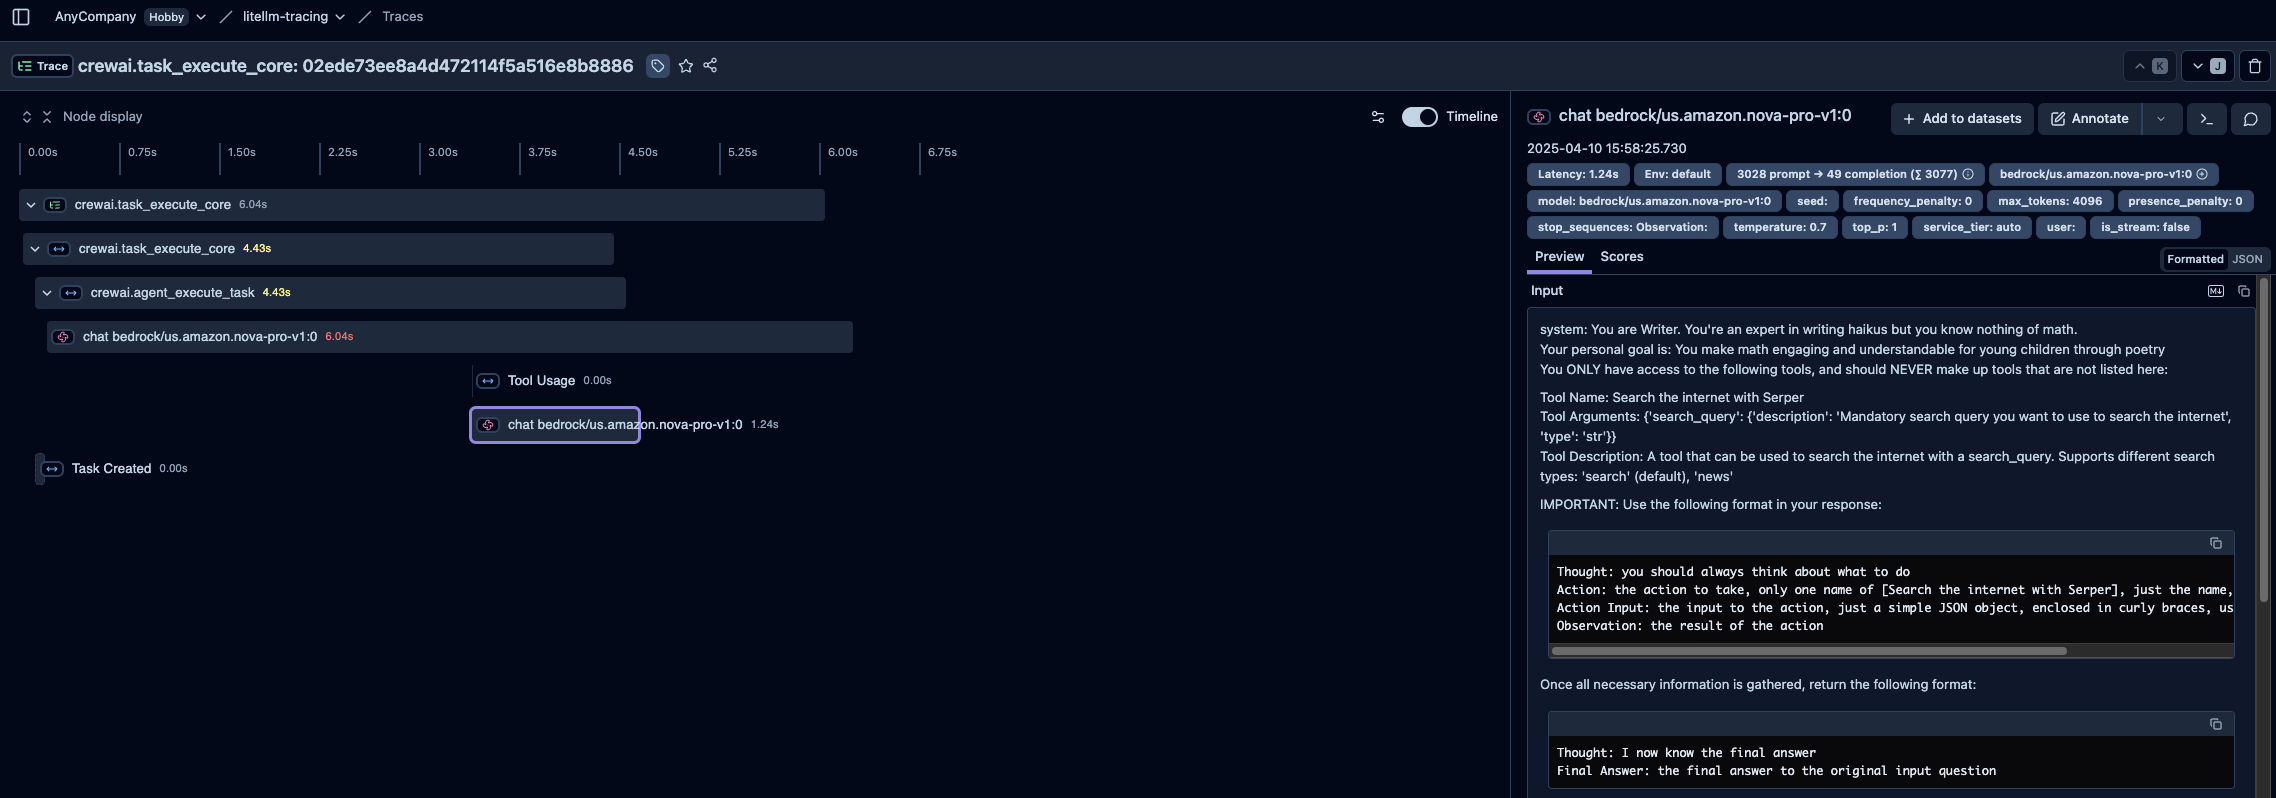